In [143]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.cm as cm

## Carga de Datos y Slicing

In [96]:
###función para cargar los datos y generar el dataframe ya revuelto usando Pandas
def CargaDatos():
    TrainingData = np.load('proyecto_training_data.npy')
    DataRegression = pd.DataFrame(TrainingData,columns =['SalePrice','OveralQual', '1stFlrSF', 'TotRmsAbvGrd', 'YearBuilt', 'LotFrontage'])
    DataRegression = DataRegression.sample(frac = 1, ignore_index=True)
    DataTrain = DataRegression.iloc[0:int(len(DataRegression)*.8),:]
    DataTest = DataRegression.iloc[int(len(DataRegression)*0.8):len(DataRegression), : ]
    

    return DataRegression, DataTrain, DataTest

In [97]:
## Main del programa
DatosProyecto, DatosEntreno, DatosPruebas = CargaDatos() #carga los datos completos, el 80% para entrenamiento y el 20% para pruebas
# Se generan 3 Data Frame, uno con los datos totales, otro con los de entreno y otro con los de pruebas.


In [98]:
pd.DataFrame.describe(DatosEntreno)

,SalePrice,OveralQual,1stFlrSF,TotRmsAbvGrd,YearBuilt,LotFrontage
count,1168.000000,1168.000000,1168.000000,1168.000000,1168.000000,959.000000
mean,181553.387842,6.105308,1163.507705,6.540240,1971.545377,70.283629
std,80784.905692,1.397159,389.727618,1.649728,30.174465,24.891180
min,34900.000000,1.000000,334.000000,2.000000,1872.000000,21.000000
25%,130000.000000,5.000000,888.000000,5.000000,1954.000000,59.000000
50%,163700.000000,6.000000,1087.000000,6.000000,1973.000000,69.000000
75%,213625.000000,7.000000,1390.250000,7.000000,2001.000000,80.000000
max,755000.000000,10.000000,4692.000000,14.000000,2010.000000,313.000000


## Histograma de la variable

<Figure size 640x480 with 0 Axes>

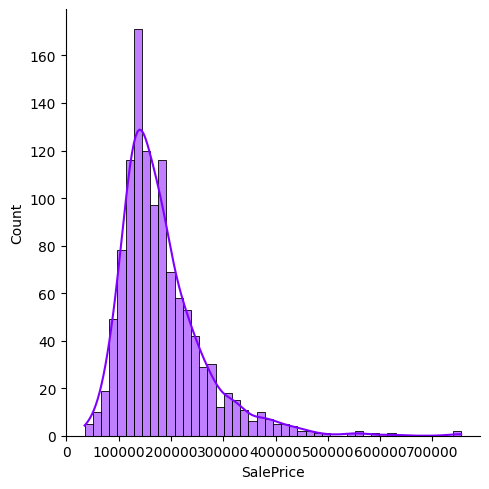

<Figure size 640x480 with 0 Axes>

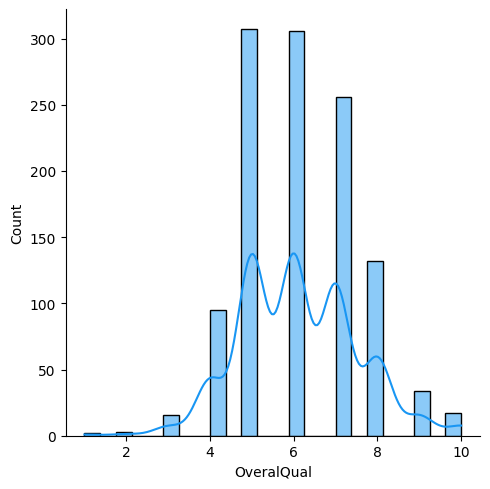

<Figure size 640x480 with 0 Axes>

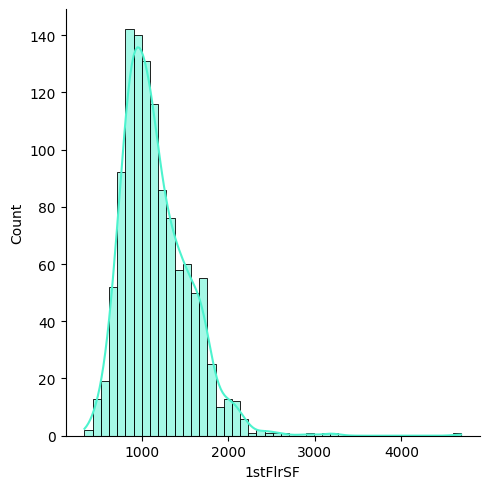

<Figure size 640x480 with 0 Axes>

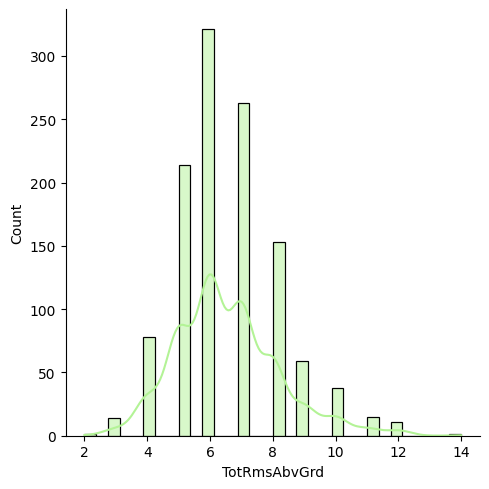

<Figure size 640x480 with 0 Axes>

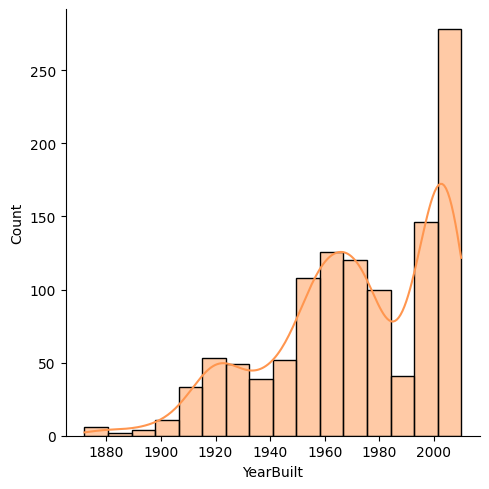

<Figure size 640x480 with 0 Axes>

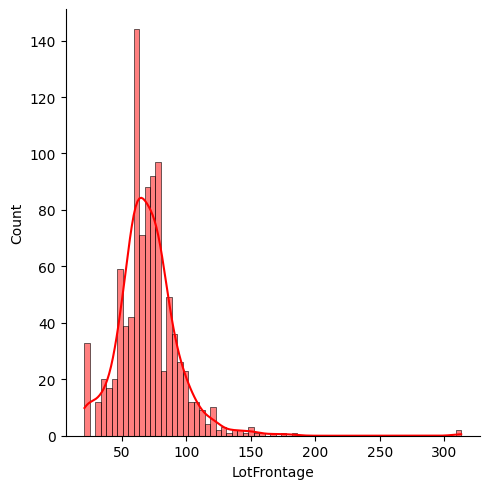

In [170]:
ColorHist = cm.rainbow(np.linspace(0,1,(DatosEntreno.shape[1])))

Ban = 0
for column in DatosEntreno:
    plt.figure()
    sb.displot(DatosEntreno[column], kde = True, color = ColorHist[Ban])
    Ban = Ban + 1

## Calcular el coeficiente de correlación de cada variable


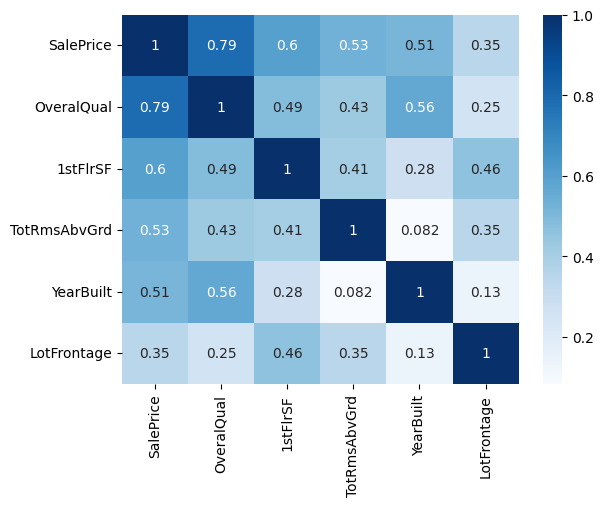

In [100]:
plt.figure()
correlacones = DatosEntreno.corr()
GrafiCorr = sb.heatmap(correlacones, annot = True, cmap = 'Blues',fmt = '0.2g')

## Scatterplot con Correlación como título

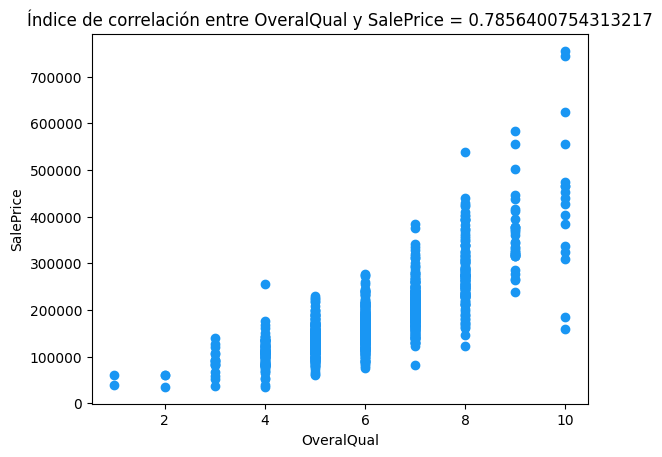

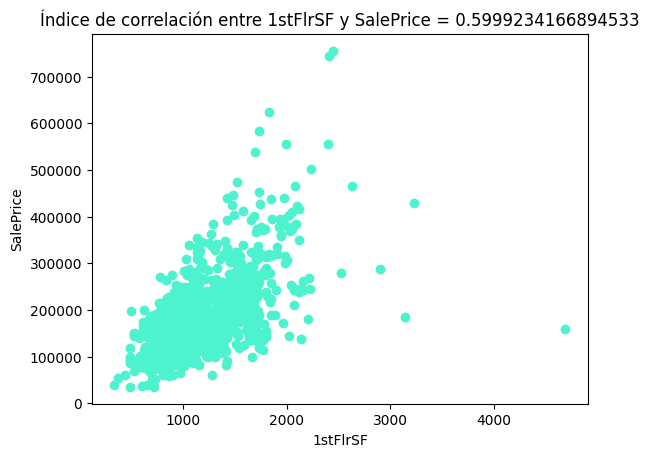

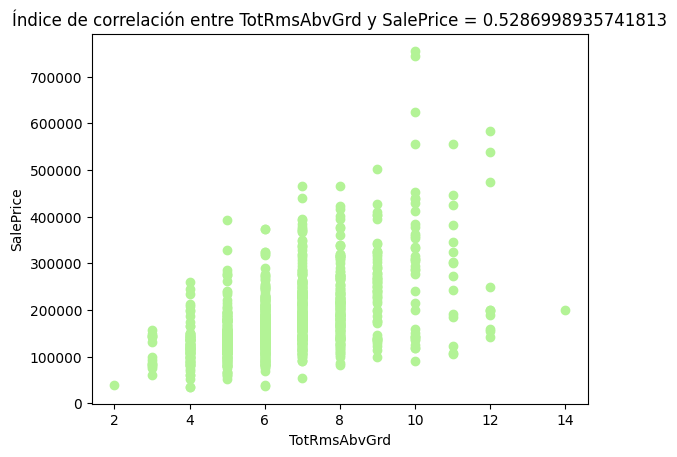

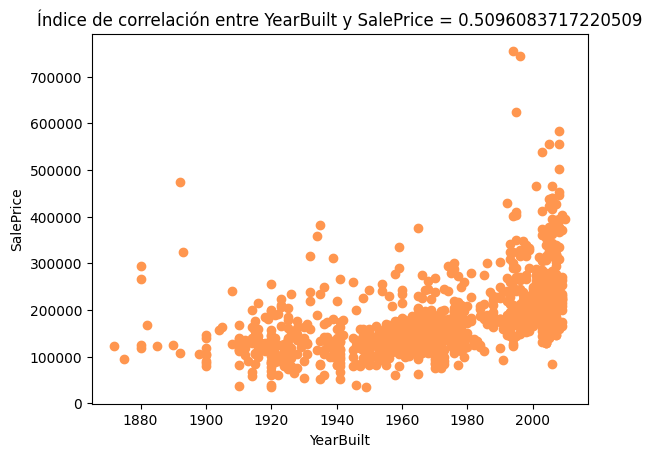

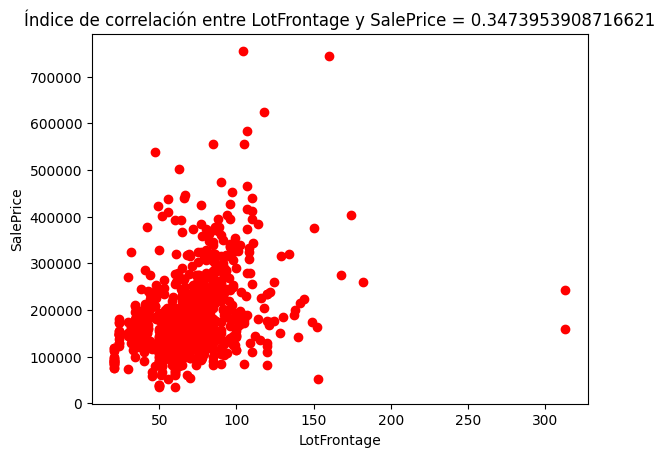

In [176]:
CorrPrecio = DatosEntreno.corr()['SalePrice']
colores = cm.rainbow(np.linspace(0,1,len(CorrPrecio)))
Bandera = 0
for value in DatosEntreno:
    if value != 'SalePrice':
        Bandera = Bandera + 1
        plt.figure()
        plt.title(f'Índice de correlación entre {value} y SalePrice = {CorrPrecio[Bandera]}')
        plt.xlabel(value)
        plt.ylabel('SalePrice')
        plt.scatter(DatosEntreno[value],DatosEntreno['SalePrice'], color = colores[Bandera])